# This notebook contains the code I used extract data for the toy flood catastrophe model
Data was extracted from larger files I downloaded from the internet (which contain either state or county-wide data), and placed in smaller files that are stored in a separate directory. These smaller files are used in the model simulations.

My apologies--the code and documentation aren't incredibly clear. I'll clean it up soon. 

In [15]:
# Import important modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Polygon,Point,LineString
from shapely import ops
from scipy import interpolate
import pickle
import warnings
plt.style.use('dark_background')
%matplotlib inline

# Define path to directory in which complete data files are saved. Also define path at which files with 
# extracted data will be stored. To run the code you'll need to save all the raw files in the directory 
# at data_path. 
data_path = './all_data'
selected_data_path = './selected_data'

# Define boundaries for the region of interest--the region surrounding Phoenicia. 
zoom_bounds = {
    'min_x': 554800.,
    'max_x': 559000.,
    'min_y': 4657000.,
    'max_y': 4660750.
}
zoom_polygon = Polygon([(zoom_bounds['min_x'],zoom_bounds['min_y']), 
                       (zoom_bounds['min_x'],zoom_bounds['max_y']),
                       (zoom_bounds['max_x'],zoom_bounds['max_y']),
                       (zoom_bounds['max_x'],zoom_bounds['min_y'])])


## Summary of files required to run the cat model: 
1. **local_DEM.pkl:** Contains DEM data for the area of interest (specified by zoom_bounds). 
2. **creeks.shp:** Shapefile with Linestrings for Esopus and Stone Clove Creeks. These linestrings are saved in three parts: one for Esopus before the confluence, one for Esopus after the confluence, and one for the Stony Clove creek. They linestrings only include points in the area of interest. 
3. **streets.shp:** Shapefile with all the streets in the area of interest. 
4. **address_points.shp:** Shapefile with all the addresspoints (properties) in the area of interest. 
5. **creek_points.csv:** CSV file that includes the X, Y, Z, creek_name, and creek point ID for all points on the creeks in creeks.shp.  
6. **dem2creek.csv:** CSV file that includes the X, Y, Z, creek_name, creek point ID, and creek_elevation for all DEM points that are relevant for flooding. The creek_name, creek point ID, and creek_elevation all correspond to the point on ANY creek that's closest to the DEM point. Only points for which $z_{DEM}-z_{creekpt} ≤ 15 m $ are included. 

In [18]:
# In this file, we determine whether the files above already exist. If they do not exist, flags are set 
# to recreate them. 
create_local_dem_pkl = not os.path.isfile(os.path.join(selected_data_path,'local_DEM.pkl'))
create_creeks_shp = not os.path.isfile(os.path.join(selected_data_path,'creeks.shp'))
create_dem2creek_csv = not os.path.isfile(os.path.join(selected_data_path,'dem2creek.csv'))
create_creek_points_csv =not  os.path.isfile(os.path.join(selected_data_path,'creek_points.csv'))
create_streets_shp = not os.path.isfile(os.path.join(selected_data_path,'streets.shp'))
create_address_points_shp = not os.path.isfile(os.path.join(selected_data_path,'address_points.shp'))
create_generator = not os.path.isfile(os.path.join(selected_data_path,'weekly_max_gage_heights.csv'))

# Or, if the file exist but we want to recreate them anyway, we can set flags to do so here. 
rewrite_data = False
if rewrite_data: 
    create_local_dem_pkl = False
    create_creeks_shp = False
    create_dem2creek_csv = False
    create_creek_points_csv = False
    create_streets_shp = False
    create_address_points_shp = True
    create_generator = False

# Functions for creating/saving data to .pkl files. 
from toy_model_module import save_load_pkl


## Extract DEM data for area of interest. 
Use the rasterio module. Also make sure to save the DEM file's CRS as the default CRS. If the file already exists and we don't want to recreate it, just load the extracted data from the selected_data_path. 

In [3]:
def retr_x_y_elev(rasterio_obj,layer=1):
    elev = rasterio_obj.read(layer)
    elev[elev<-5000]=np.nan
    mesh_x = np.zeros(np.shape(elev))
    mesh_y = np.zeros(np.shape(elev))
    for i in range(np.shape(elev)[0]):
        for j in range(np.shape(elev)[1]):
            coords = rasterio_obj.xy(i,j)
            mesh_x[i,j] = coords[0]
            mesh_y[i,j] = coords[1]
    return mesh_x,mesh_y,elev

# Read DEM file. Save CRS as default CRS
dem1 = rasterio.open(os.path.join(data_path,'dem','x44elu.dem'))
elev_x,elev_y,elev = retr_x_y_elev(dem1,layer=1)
default_crs = dem1.crs

# Extract DEM for area of interest. 
if create_local_dem_pkl:

    # Now isolate data from the region we're zooming in on. 
    thresh = 0
    ixn = (np.abs(elev_x[0,:]-zoom_bounds['min_x']+thresh)).argmin()
    ixx = (np.abs(elev_x[0,:]-zoom_bounds['max_x']-thresh)).argmin()
    iyn = (np.abs(elev_y[:,0]-zoom_bounds['max_y']-thresh)).argmin()
    iyx = (np.abs(elev_y[:,0]-zoom_bounds['min_y']+thresh)).argmin()
    zoom_x = elev_x[iyn:iyx,ixn:ixx] # need to be careful here... dem coordinate system goes from top left
    zoom_y = elev_y[iyn:iyx,ixn:ixx] # to bottom right.
    zoom_elev = elev[iyn:iyx,ixn:ixx]
    
    local_dem = {'dem_X': zoom_x, 'dem_Y': zoom_y, 'dem_Z': zoom_elev, 'zoom_bounds': zoom_bounds, 'crs': default_crs}
    save_load_pkl.save_obj(local_dem, os.path.join(selected_data_path,'local_DEM.pkl'))
    
else: 
    
    local_dem = save_load_pkl.load_obj(os.path.join(selected_data_path,'local_DEM.pkl'))
    zoom_x,zoom_y,zoom_elev,zoom_bounds,default_crs = local_dem['dem_X'],local_dem['dem_Y'],local_dem['dem_Z'],local_dem['zoom_bounds'],local_dem['crs']
    
    

/Users/Lucien/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


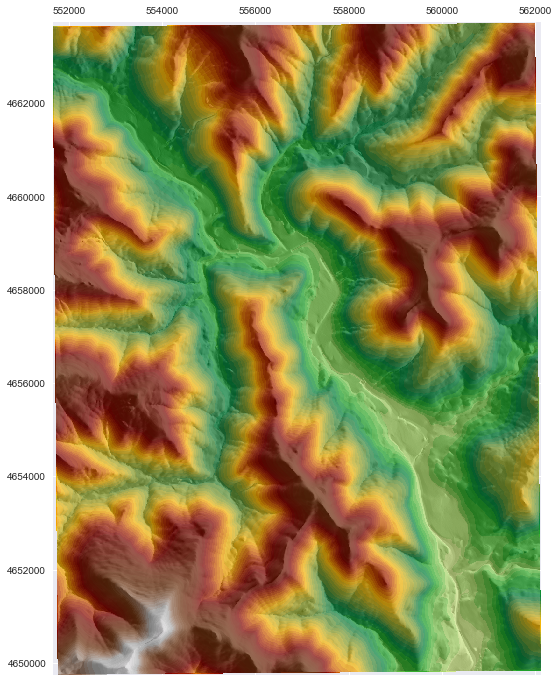

In [4]:
# Plot all DEM data in the file because it looks nice! 

# Set colormap
try:
    import pycpt
    topocmap = pycpt.load.cmap_from_cptcity_url('wkp/schwarzwald/wiki-schwarzwald-cont.cpt')
except:
    topocmap = 'gist_earth'
    
# Function for adding hillshade
def hillshade(array, azimuth, angle_altitude):
    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

# Plot
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
extent = xmin,xmax,ymin,ymax = dem1.bounds[0],dem1.bounds[2],dem1.bounds[1],dem1.bounds[3]
ax.matshow(hillshade(elev, 30, 30), extent=extent, cmap='Greys', alpha=.3,zorder=10)
CS = ax.contourf(elev_x,elev_y,elev,levels=50,cmap=topocmap,vmin=0, vmax=1200)
#ax.set_xlim((zoom_bounds['min_x'],zoom_bounds['max_x']))
#ax.set_ylim((zoom_bounds['min_y'],zoom_bounds['max_y']))
plt.show()



## Extract stream data
Load stream data for the entirety of Ulster county. Extract the linestrings in the shapefile that lie at least partially in the area of interest. Then trim the linestrings to that all points in the linestrings lie in the area of interest. Finally, add points to the linestrings so that the linestrings are defined by points every ten meters. This will minimize discontinuities in the flood inundations that are calculated in the model. 

/Users/Lucien/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


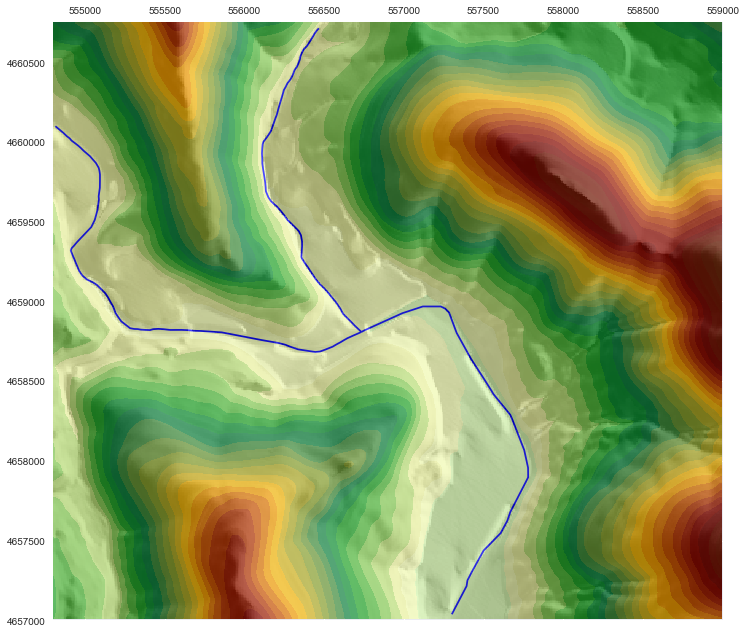

In [5]:
# Pull out the shapefile objects that correspond to the Esopus and Stony Clove Creeks, 
# which are the main creeks that go through Phoenicia. 

def extract_in_box(geo_df,box_polygon):
    for index,row in geo_df.iterrows():
        obj_geom = geo_df['geometry'][index]
        
        if obj_geom.geom_type == 'LineString': 
            if not obj_geom.intersects(box_polygon):
                geo_df = geo_df.drop(index, axis=0)
                
        elif obj_geom.geom_type == 'Point': 
            if not box_polygon.contains(obj_geom): 
                geo_df = geo_df.drop(index, axis=0)
        
    return geo_df

def trim_linestring_to_box(line_string,box_polygon):
    coord_in_zoom = []
    for point in line_string.coords:
        point = Point(point)
        if point.within(box_polygon):
            coord_in_zoom.append(point)
    line_string_cut = LineString(coord_in_zoom)
    return line_string_cut

def linestring_incr_resol(line_string,resol=20):
    new_coords = []
    for i in range(len(line_string.coords)-1):
        del_x = line_string.coords[i+1][0]-line_string.coords[i][0]
        del_y = line_string.coords[i+1][1]-line_string.coords[i][1]
        del_z = line_string.coords[i+1][2]-line_string.coords[i][2]
        del_x_res = resol*del_x/(np.sqrt((del_x**2)+(del_y**2)))
        del_y_res = resol*del_y/(np.sqrt((del_x**2)+(del_y**2)))
        del_z_res = resol*del_z/(np.sqrt((del_x**2)+(del_y**2)+(del_z**2)))
        new_points_x = np.arange(line_string.coords[i][0],line_string.coords[i+1][0],del_x_res)
        new_points_y = np.arange(line_string.coords[i][1],line_string.coords[i+1][1],del_y_res)
        new_points_z = np.arange(line_string.coords[i][2],line_string.coords[i+1][2],del_z_res)
        for new_x,new_y,new_z in zip(new_points_x,new_points_y,new_points_z):
            new_coords.append(Point([new_x,new_y,new_z]))
    new_coords.append(line_string.coords[-1])
    new_coords_lstr = LineString(new_coords)    
    return new_coords_lstr
    
    
if create_creeks_shp: 
    
    # Read stream data from shapefiles. 
    streams = gpd.read_file(os.path.join(data_path,'hydrography','Ulster-County-Hydrography','Streams.shp'))
    streams = streams.to_crs(default_crs)

    # Isolate stream segments from ONLY Esopus and Sonty Clove Creeks. 
    esopus_gdf = streams.loc[streams['NAME'] == 'Esopus Creek']
    sclove_gdf = streams.loc[streams['NAME'] == 'Stony Clove Creek']

    # Remove all linestrings that aren't within the zoom bounding box. 
    esopus_gdf = extract_in_box(esopus_gdf,zoom_polygon)
    sclove_gdf = extract_in_box(sclove_gdf,zoom_polygon)

    # Dissolve pieces of both creeks into two MULTILINESTRINGS (one for each creek). 
    esopus = esopus_gdf.dissolve(by='NAME')
    sclove = sclove_gdf.dissolve(by='NAME')

    # Then merge the MULTILINESTRINGS into single LINESTRINGS. 
    esopus['geometry'] = ops.linemerge(esopus['geometry'][0])
    sclove['geometry'] = ops.linemerge(sclove['geometry'][0])

    # Trim the ends of these linestrings so that they fit completely in the 'zoom' polygon. 
    esopus['geometry'] = trim_linestring_to_box(esopus['geometry'][0],zoom_polygon)
    sclove['geometry'] = trim_linestring_to_box(sclove['geometry'][0],zoom_polygon)

    # Finally, increase resolution of the linestrings to that we have points AT LEAST every 20m. 
    esopus['geometry'] = linestring_incr_resol(esopus['geometry'][0],resol=10)
    sclove['geometry'] = linestring_incr_resol(sclove['geometry'][0],resol=10)

    # Now split the esopus linestring into two, at the point it intersects with the stony clove linestring. 
    # Then add linestrings corresponding to esopus, stony clove, esopus after stony clove to a single 
    # geodataframe. 

    from shapely.ops import split

    # Retrieve split point--last point on sclove linestring. 
    x_split,y_split = sclove['geometry'][0].coords[-1][0],sclove['geometry'][0].coords[-1][1]

    # Find point on esopus linestring that's closest to the split point. 
    dist_sclove_esopus = [np.sqrt((coord[0]-x_split)**2+(coord[1]-y_split)**2) for coord in esopus['geometry'][0].coords]
    ind_split = int((np.abs(dist_sclove_esopus).argmin()))

    # Split esopus linestring at that point. 
    result = split(esopus['geometry'][0],Point(esopus['geometry'][0].coords[ind_split]))

    # Then create the new geodataframe. 
    split_esopus = [p for p in result]
    df = pd.DataFrame(
        {'NAME': ['esopus', 'stony_clove', 'merged'],
         'Source': ['NYCDEP', 'NYCDEP', 'NYCDEP'],
         'Shape_STLe': [esopus['Shape_STLe'][0], sclove['Shape_STLe'][0], esopus['Shape_STLe'][0]],
         'geometry': [split_esopus[0], sclove['geometry'][0], split_esopus[1]]})
    creeks = gpd.GeoDataFrame(df, geometry='geometry')
    
    creeks.to_file(os.path.join(selected_data_path,'creeks.shp'))
    
else: 
    
    creeks = gpd.read_file(os.path.join(selected_data_path,'creeks.shp'))
    

# Plot streams in zoomed region. 
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
extent = xmin,xmax,ymin,ymax = min(zoom_x[0,:]),max(zoom_x[0,:]),min(zoom_y[:,0]),max(zoom_y[:,0])
ax.matshow(hillshade(zoom_elev, 30, 30), extent=extent, cmap='Greys', alpha=.3,zorder=10)
CS = ax.contourf(zoom_x,zoom_y,zoom_elev,levels=30,cmap=topocmap,vmin=150, vmax=1000)
creeks.plot(ax=ax,color='b')
ax.set_xlim((zoom_bounds['min_x'],zoom_bounds['max_x']))
ax.set_ylim((zoom_bounds['min_y'],zoom_bounds['max_y']))
plt.show()



## Create CSV file that lists information on creek points
x coordinate, y coordinate, elevation, creek name, and creek point ID number for all 'creek points,' or points that are used to define the creeks in the shapefiles. This is required for my method of calculating the flood extent and inundation around Phoenicia. 

In [6]:
if create_creek_points_csv: 
    
    x_crk,y_crk,z_crk,nm_crk,pt_id = [],[],[],[],[]
    id_counter = 0
    z_interp = interpolate.RegularGridInterpolator(points=(np.flipud(zoom_y[:,0]),zoom_x[0,:]),values=np.flipud(zoom_elev),method='linear')
    for nm,ls in zip(creeks['NAME'],creeks['geometry']): 
        for i,coord in enumerate(ls.coords):
            x_crk.append(coord[0])
            y_crk.append(coord[1])
            z_pt = z_interp((coord[1],coord[0]))
            z_crk.append(z_pt)
            nm_crk.append(nm)
            pt_id.append(id_counter)
            id_counter += 1

    crkpt = pd.DataFrame({
        'X': x_crk,
        'Y': y_crk,
        'Z': z_crk,
        'crk_nm': nm_crk,
        'crkpt_id': pt_id,
    })
    
    crkpt.to_csv(os.path.join(selected_data_path,'creek_points.csv'))
    
else: 
    
    crkpt = pd.read_csv(os.path.join(selected_data_path,'creek_points.csv'))


## Create CSV file that lists creek information for DEM points. 

For each DEM point, list: X coordinate, Y coordinate, elevation, name of nearest creek, ID of nearest creek point, elevation of nearest creek point. Remove all DEM points that aren't within 15 vertical meters of their nearest creek point (to make sure the file stays small). 

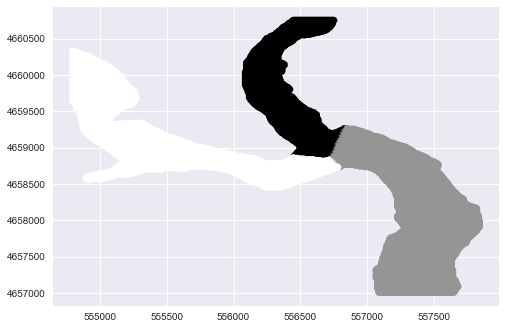

In [7]:
if create_dem2creek_csv: 
    
    X,Y,Z,nm_crk,pt_id,z_crk = [],[],[],[],[],[]
    for x,y,z in zip(zoom_x.ravel(),zoom_y.ravel(),zoom_elev.ravel()): 
        X.append(x)
        Y.append(y)
        Z.append(z)
        dist_all = [np.sqrt((x-x_crk)**2+(y-y_crk)**2) for x_crk,y_crk in zip(crkpt['X'],crkpt['Y'])]
        i_nearest = int(np.asarray(dist_all).argmin())
        nm_crk.append(crkpt['crk_nm'][i_nearest])
        pt_id.append(crkpt['crkpt_id'][i_nearest])
        z_crk.append(crkpt['Z'][i_nearest])

    dem2crk = pd.DataFrame({
        'X': X,
        'Y': Y,
        'Z': Z,
        'crk_nm': nm_crk,
        'crkpt_id': pt_id,
        'z_crk': z_crk
    })

    dem2crk = dem2crk[dem2crk['Z']-dem2crk['z_crk'] <= 15]
    
    dem2crk.to_csv(os.path.join(selected_data_path,'dem2creek.csv'))

else: 
    
    dem2crk = pd.read_csv(os.path.join(selected_data_path,'dem2creek.csv'))


# Plot to check that the code above worked.
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
encoded_creek = lb_make.fit_transform(dem2crk['crk_nm'])
plt.figure()
plt.scatter(dem2crk['X'], dem2crk['Y'], c=encoded_creek)
plt.show()


## Create shapefile that includes all streets/roads in area of interest
Load all streets in Ulster county, extract all streets in the area of interest, and save streets to a new shapefile. 

In [8]:
# Create shapefile with streets in the area of interest (or read if it already exists)

if create_streets_shp: 
    
    # Read in the file with all streets in NYS. Change CRS to default for this project. 
    all_streets = gpd.read_file(os.path.join(data_path,'streets','SimplifiedStreets_shp','SimplifiedStreetSegmentQrt.shp'))
    all_streets = all_streets.to_crs(default_crs)
    
    # Extract streets in area of interest. For speed, only search streets in Ulster county 
    ulster_streets = all_streets[all_streets['LeftCounty'] == 'Ulster']
    zoom_streets = extract_in_box(ulster_streets,zoom_polygon)
    
    # Dissolve to connect streets with common names. 
    zoom_streets = zoom_streets.dissolve(by='Label')
        
    # Trimming these streets to the area of interest is too complicated, so I'm just going to save 
    # these as is. There aren't many of them so the file won't be that much bigger. 
    zoom_streets.to_file(os.path.join(selected_data_path,'streets.shp'))
    
else: 
    
    # Read the file if it already exists. 
    zoom_streets = gpd.read_file(os.path.join(selected_data_path,'streets.shp'))
    

## Create shapefile that includes all addresspoints in area of interest
Load all addresspoints in NY state, extract all addresspoints in the area of interest, and save points to a new shapefile. 

In [9]:
# Create shapefile with addresspoints in area of interest (or read file if it already exists). 

if create_address_points_shp: 

    # Read in the file with all streets in Ulster County. Change CRS to default for this project. 
    all_adpts = gpd.read_file(os.path.join(data_path,'address_points','Address_Points_Ulster_shp','AddressPoints_Ulster.shp'))
    all_adpts = all_adpts.to_crs(default_crs)

    # Extract addresspoints in area of interest. For speed, only search streets in ziplist = 
    # [12464,12457,12416]
    subset_adpts = all_adpts.copy()
    subset_adpts = subset_adpts[(subset_adpts['ZipCode'] == '12464') | (subset_adpts['ZipCode'] == '12457') | (subset_adpts['ZipCode'] == '12416')]
    zoom_adpts = extract_in_box(subset_adpts,zoom_polygon)
    
    # Clean the addresspoint data.
    # 1. Remove addresspoint that flood with <= 1 m of flooding. There must be errors with the data at these points. 
    foc_adpts = zoom_adpts
    flood_w_no_flood = ['ULST081590','ULST053538','ULST053536','ULST053388','ULST053387','ULST053398',
                        'ULST071206','ULST059118','ULST053179','ULST053312','ULST082407','ULST053243',
                        'ULST053247','ULST072062','ULST059120','ULST053559','ULST081589','ULST053537',
                        'ULST081608','ULST059117','ULST053177','ULST053178','ULST053310','ULST053309']
    for nysad in flood_w_no_flood: 
        foc_adpts = foc_adpts[foc_adpts['NYSAddress']!=nysad]

    # 2. Remove all addresspoints that aren't primary addresses--we want to only count properties 
    # with multiple units once. 
    foc_adpts = foc_adpts[foc_adpts['PrimaryPoi']=='Y']

    # Assign whether each property is commerical or residential. 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        foc_adpts['PropertyType'] = np.zeros(np.shape(foc_adpts['NYSAddress']))
        foc_adpts['PropertyType'][(foc_adpts['StreetName']!='Main') | (foc_adpts['Unincorpor']!='Phoenicia') | (foc_adpts['AddressNum']>=90)] = 'residential'
        foc_adpts['PropertyType'][(foc_adpts['StreetName']=='Main') & (foc_adpts['Unincorpor']=='Phoenicia') & (foc_adpts['AddressNum']<90)] = 'commercial'

    # Also assign costs of replacement according to the rules described above. 
    cor = []
    np.random.RandomState(seed=42)
    for index,row in foc_adpts.iterrows():
        if row['PropertyType'] == 'residential': 
            repl = max(np.random.normal(loc=290,scale=70),50)
            cor.append(repl*1000)
        elif row['PropertyType'] == 'commercial':
            repl = max(np.random.normal(loc=300,scale=100),25)
            cor.append(repl*1000)

    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        foc_adpts['CostOfReplacement'] = pd.Series(cor, index=foc_adpts.index)

    # Save to shapefile. 
    foc_adpts.to_file(os.path.join(selected_data_path,'address_points.shp'))
    
else: 
    
    zoom_adpts = gpd.read_file(os.path.join(selected_data_path,'address_points.shp'))



/Users/Lucien/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


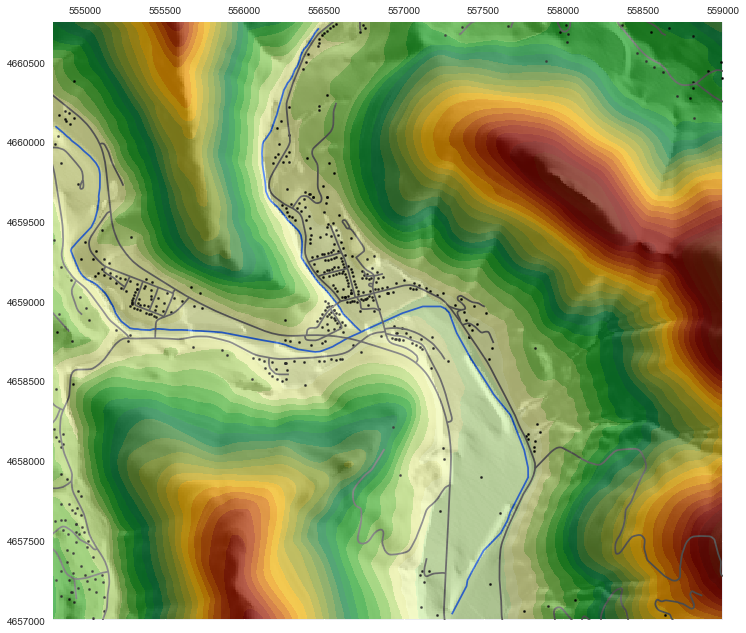

In [10]:
# Plot everything in zoomed region to make sure everything worked well. 
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
extent = xmin,xmax,ymin,ymax = min(zoom_x[0,:]),max(zoom_x[0,:]),min(zoom_y[:,0]),max(zoom_y[:,0])
ax.matshow(hillshade(zoom_elev, 30, 30), extent=extent, cmap='Greys', alpha=.3,zorder=10)
CS = ax.contourf(zoom_x,zoom_y,zoom_elev,levels=30,cmap=topocmap,vmin=150, vmax=1000)
creeks.plot(ax=ax,color='#1D64F3')
zoom_streets.plot(ax=ax,color='#696969')
zoom_adpts.plot(ax=ax,color='k',markersize=5)
ax.set_xlim((zoom_bounds['min_x'],zoom_bounds['max_x']))
ax.set_ylim((zoom_bounds['min_y'],zoom_bounds['max_y']))
plt.show()

## Finally, create the CSV file used for event generation. 
Load time series of gage heights from the Esopus and Stony Clove creeks. Determine $gh_e$ and $gh_s$ at time with greatest $gh_e^2+gh_s^2$ during each week, save those $gh_e$ and $gh_s$ values along with the month to a .csv file.

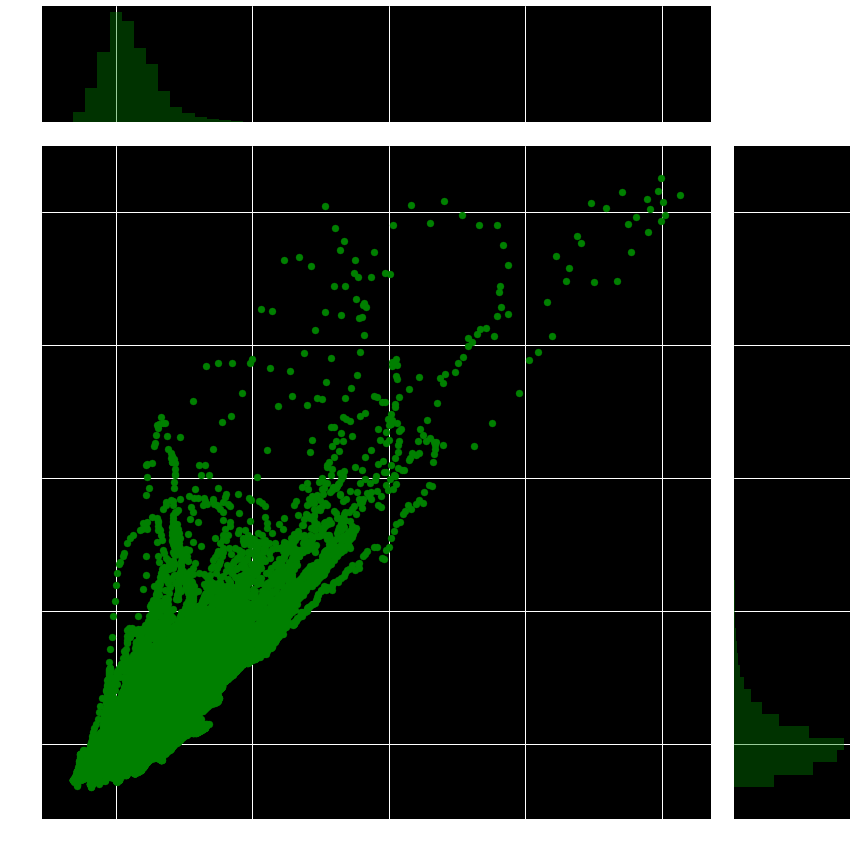

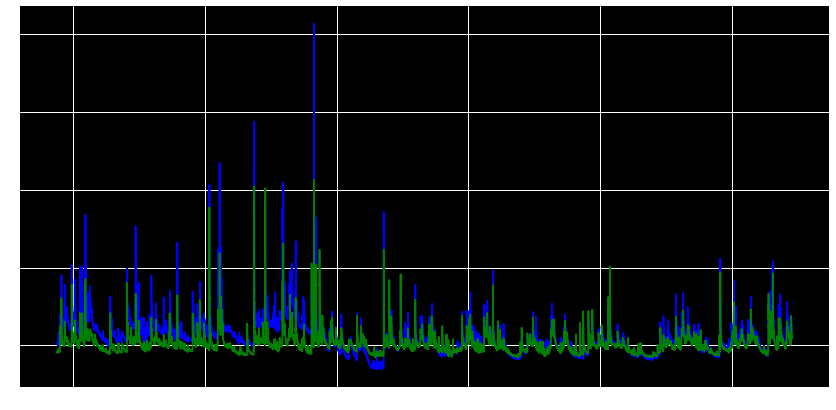

In [21]:
# Read gage data from both streams, place in dataframe. 

def read_gage_file(path_fname): 
    
    # Open file. 
    with open(path_fname) as f: 
        gage = f.readlines()

    # Determine index where the table header begins. 
    ind,fst_char = 0,'#'
    while fst_char == '#': 
        ind+=1
        fst_char = gage[ind][0]    
    
    # Isolate header and data table. 
    gage_head = gage[ind:ind+2]
    gage_data = gage[ind+2:]

    # Initialize lists to store data. 
    agency_id, site_no, dtime, time_zone, discharge_cfs, discharge_cfs_cd, gage_height_ft, \
            gage_height_ft_cd = [],[],[],[],[],[],[],[]

    # Determine which columns in table correspond to gage height and discharge measurements. 
    col_discharge = [ind for ind,head in 
                     enumerate(gage_head[0].rstrip().split('\t')) if head[-5:] == '00060'][0] 
    
    col_gage = [ind for ind,head in 
                enumerate(gage_head[0].rstrip().split('\t')) if head[-5:] == '00065'][0]    

    # Loop through lines, add data to appropriate lists. 
    for i,line in enumerate(gage_data): 

        # Strip off newline 
        chomped_line = line.rstrip() 

        # Split line by spaces
        split_line = chomped_line.split('\t')

        # Replace empty entries with nans. 
        for j,entry in enumerate(split_line): 
            if not entry: 
                split_line[j] = np.nan

        # Add data to lists. 
        agency_id.append(split_line[0])
        site_no.append(split_line[1])
        dtime.append(split_line[2])
        time_zone.append(split_line[3])
        
        # Idenfitying data in last four columns is pretty tricky... sometimes 
        # If less than 8 columns, no data for gage_height_ft or gage_height_ft_cd and enter nans. 
        # If ≥ 8, then add data for those two variables to lists. 
        if len(split_line) == 8: 
            discharge_cfs.append(split_line[col_discharge])
            discharge_cfs_cd.append(split_line[col_discharge+1])
            gage_height_ft.append(split_line[col_gage])
            gage_height_ft_cd.append(split_line[col_gage+1])
        elif len(split_line) == 6 and col_gage == 6: 
            discharge_cfs.append(split_line[col_discharge])
            discharge_cfs_cd.append(split_line[col_discharge+1])
            gage_height_ft.append(np.nan)
            gage_height_ft_cd.append(np.nan)
        elif len(split_line) == 6 and col_gage == 4: 
            discharge_cfs.append(np.nan)
            discharge_cfs_cd.append(np.nan)
            gage_height_ft.append(split_line[col_gage])
            gage_height_ft_cd.append(split_line[col_gage+1])
        else: 
            message = 'Issue with loading... this function encountered a line of the file it '+ \
                'could not make sense of: ' + str(i)
            error(message)
    
    # Place data in a single dataframe. 
    gage_df = pd.DataFrame({
        'agency_id': agency_id,
        'site_no': site_no, 
        'dtime': dtime, 
        'time_zone': time_zone, 
        'discharge_cfs': discharge_cfs, 
        'discharge_cfs_cd': discharge_cfs_cd, 
        'gage_height_ft': gage_height_ft, 
        'gage_height_ft_cd': gage_height_ft_cd
    })
    
    return gage_df


if create_generator: 

    esopus_gage = read_gage_file(os.path.join(data_path,'stream_gage','esopus_allaben_gage'))
    sclove_gage = read_gage_file(os.path.join(data_path,'stream_gage','stony_clove_chinchester_gage'))

    # Merge the two stream gage dataframes using 'inner' strategy. This will place all measurements in 
    # a single dataframe and ensure that values are only given at times when measurements are given for 
    # both the stony clove and esopus creeks. 
    merged_gage = sclove_gage.merge(esopus_gage[['dtime','discharge_cfs','discharge_cfs_cd','gage_height_ft',
                                                 'gage_height_ft_cd']],how='inner',on='dtime',
                                                 suffixes=('_s','_e'))

    # Convert measurements to floats. 
    merged_gage['discharge_cfs_s'] = merged_gage['discharge_cfs_s'].apply(lambda x: float(x))
    merged_gage['gage_height_ft_s'] = merged_gage['gage_height_ft_s'].apply(lambda x: float(x))
    merged_gage['discharge_cfs_e'] = merged_gage['discharge_cfs_e'].apply(lambda x: float(x))
    merged_gage['gage_height_ft_e'] = merged_gage['gage_height_ft_e'].apply(lambda x: float(x))

    # Convert datestrings to python datetimes. 
    merged_gage['dtime'] = merged_gage['dtime'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M'))

    # Delete large, unneeded dataframes from memory. 
    del(esopus_gage,sclove_gage)

    # Re-express the gage heights as relative to a baseline gage height, which is the height that is most frequently observed. 
    # esopus: ~2.75, stony clove: ~2.5. 
    freq,edge = np.histogram(merged_gage['gage_height_ft_e'][np.isnan(merged_gage['gage_height_ft_e'])!=1],bins=50)
    esopus_baseline = np.mean(edge[np.argmax(freq):np.argmax(freq)+2])
    freq,edge = np.histogram(merged_gage['gage_height_ft_s'][np.isnan(merged_gage['gage_height_ft_s'])!=1],bins=50)
    sclove_baseline = np.mean(edge[np.argmax(freq):np.argmax(freq)+2])
    merged_gage['esopus_rel_gh_m'] = (merged_gage['gage_height_ft_e']-esopus_baseline)*0.3048
    merged_gage['sclove_rel_gh_m'] = (merged_gage['gage_height_ft_s']-sclove_baseline)*0.3048

    # Visualize the gage height on esopus vs gage height on stony clove with hexplot. 
    sns.jointplot('esopus_rel_gh_m','sclove_rel_gh_m',data=merged_gage,kind='scatter',color='g',dropna=True,height=12)#,xlim=(1.5,8),ylim=(2,6))
    plt.show()

    # Also visualize with time series of gage heights on both creeks.  
    plt.figure(figsize=(14.5, 7))
    plt.plot(merged_gage['dtime'],merged_gage['esopus_rel_gh_m'],'b-')
    plt.plot(merged_gage['dtime'],merged_gage['sclove_rel_gh_m'],'g-')
    plt.grid(True)
    plt.show()

    # Create weekly event generator. 

    # Metric to identify time with the highest flood waters. 
    merged_gage['max_metric'] = (merged_gage['esopus_rel_gh_m']-merged_gage['esopus_rel_gh_m'].min())**2 + \
                                (merged_gage['sclove_rel_gh_m']-merged_gage['sclove_rel_gh_m'].min())**2

    # Loop through all the weeks in our gage height measurements. For each week, find time with the highest
    # metric value and record the gage heights for both creeks at that time. Also record the month in which 
    # the center of that week falls. Skip a week if more than half the measurements are NaN's. Stop the while 
    # loop when the end of the following week falls outside the range of measurements. 

    keep_going = 1
    time_interval = datetime.timedelta(weeks=1)
    time_st = merged_gage['dtime'][0]
    max_gh_esopus,max_gh_sclove,gage_hgts_months = [],[],[]

    while keep_going == 1: 

        ind_st = merged_gage['dtime'].where(merged_gage['dtime'] >= time_st).idxmin()
        time_ed = time_st+time_interval
        ind_ed = merged_gage['dtime'].where(merged_gage['dtime'] >= time_ed).idxmin()

        num_nans = sum(np.isnan(merged_gage['max_metric'][ind_st:ind_ed]))
        if num_nans/len(merged_gage['max_metric'][ind_st:ind_ed]) <= 0.5: 
            ind_mm = (merged_gage['max_metric'][ind_st:ind_ed]).idxmax()
            max_gh_esopus.append(merged_gage['esopus_rel_gh_m'][ind_mm])
            max_gh_sclove.append(merged_gage['sclove_rel_gh_m'][ind_mm])
            gage_hgts_months.append(datetime.datetime.strftime(merged_gage['dtime'][(ind_st+ind_ed)//2],'%m'))

        if time_ed+time_interval > merged_gage['dtime'].iloc[-1]: 
            keep_going = 0

        time_st = time_ed


    # Create dataframe with weekly maximum gage heights. 
    weekly_max_gh = pd.DataFrame({
        'month': gage_hgts_months,
        'esopus': max_gh_esopus, 
        'stony_clove': max_gh_sclove 
    })

    # Save to csv
    weekly_max_gh.to_csv(os.path.join(selected_data_path,'weekly_max_gage_heights.csv'))
    
else: 
    
    weekly_max_gh = pd.read_csv(os.path.join(selected_data_path,'weekly_max_gage_heights.csv'))
